In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device, batch_data_by_country

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
import utils.results as results
import torch
import torch.nn as nn

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [2]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction
device = get_device()

In [3]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [4]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_hf = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.005, 0.05, 0.1], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

x_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
x_valid_t = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device)
x_hf_t = torch.tensor(x_hf, dtype=torch.float32).to(device)

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Smoothing Model

In [5]:
preprocessor.dates_high_freq
preprocessor.country_high_freq

df_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': [x_hf[i] for i in range(len(x_hf))]
})

df_x_train = pd.DataFrame({
    'date': preprocessor.dates_train.copy(),
    'country': preprocessor.country_train.copy(),
    'data': [X_train[i].copy() for i in range(len(X_train))],
    'y_true': [y_train[i].copy() for i in range(len(y_train))]
})

df_hf['date'] = pd.to_datetime(df_hf['date'])
df_x_train['date'] = pd.to_datetime(df_x_train['date'])

In [6]:
from torch.nn import MSELoss

def compute_smoothness_loss(y_pred, smoothness_weight_ord1=0.33, smoothness_weight_ord2=0.33):
    if y_pred.shape[1] > 1:
        # Compute the loss related to smoothness
        smoothness_loss_ord1 = 0
        for i in range(1, 4):
            # Divide by 3 because dt is 1/3 month, and by 4 because we have 4 time points and we average them
            smoothness_loss_ord1 += torch.linalg.norm((y_pred[:, i, :] - y_pred[:, i - 1, :])) ** 2 / (3 * 4 * y_pred.shape[0])

        # Constraint on the double derivative
        smoothness_loss_ord2 = 0
        for i in range(2, 4):
            smoothness_loss_ord2 += torch.linalg.norm(y_pred[:, i, :] - 2 * y_pred[:, i - 1, :] + y_pred[:, i - 2, :]) ** 2 / (3 * 4 * y_pred.shape[0])

        return smoothness_loss_ord1 * smoothness_weight_ord1 + smoothness_loss_ord2 * smoothness_weight_ord2

    else:
        raise ValueError("Input shape not supported!")

def custom_loss(y_pred, y_true, smoothness_weight_ord1=0.33, smoothness_weight_ord2=0.33):
    # Compute usual MSE on actual GDP values
    mse = MSELoss()

    if y_pred.shape[1] > 1:
        prediction_loss = mse(y_pred[:, -1, :], y_true)  # First column is the actual GDP

        smooth_loss = compute_smoothness_loss(y_pred, smoothness_weight_ord1, smoothness_weight_ord2)

        return prediction_loss + smooth_loss
    elif y_pred.shape[1] == 1:
        return mse(y_pred, y_true)
    else:
        raise ValueError("Input shape not supported!")

In [7]:
augmented_data, filtered_countries, filtered_dates, y_augmented_train, _ = batch_data_by_country(df_x_train, 
                                                                                              df_hf, 
                                                                                              3, 
                                                                                              0, 
                                                                                              ['y_true'], 
                                                                                              False)

y_augmented_train = np.array(y_augmented_train).squeeze().astype(np.float32)

Using cuda device


100%|██████████| 100/100 [00:01<00:00, 74.18it/s]


Final training loss: 0.3424457907676697
Final validation loss: 0.43573638796806335
Final validation R^2: 0.42077457170289945


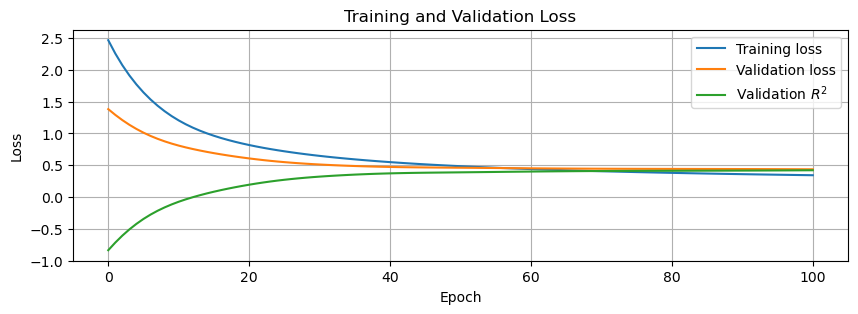

[0.011580969043636105, 0.09067216009463903]

In [8]:
smoothness_weight_ord1=5
smoothness_weight_ord2=10
model, training_loss, validation_loss, validation_r_squared, global_mse_losses = train_nn(augmented_data, 
                                                                        y_augmented_train, 
                                                                        X_valid, 
                                                                        y_valid, 
                                                                        num_epochs=100, 
                                                                        learning_rate=1e-4, 
                                                                        weight_decay=1e-2, 
                                                                        verbose=True,
                                                                        current_gdp_idx=-1,
                                                                        custom_loss=lambda x, y: custom_loss(x, y, smoothness_weight_ord1, smoothness_weight_ord2),
                                                                        seed=SEED)
global_mse_losses[-1]

In [9]:
device = get_device(False)

# Get the predictions
y_pred = model(x_valid_t).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train_t).clone().detach().cpu().numpy().squeeze()
y_pred_hf = model(x_hf_t).clone().detach().cpu().numpy().squeeze()

In [10]:

# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])
predictions_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'y_pred': y_pred_hf,
    'Set': 'High Frequency'
})


# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

predictions_hf_melted = predictions_hf.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    filtered_data_hf = predictions_hf_melted[predictions_hf_melted["country"] == selected_country]

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data_hf,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True, palette="Set3"
    )
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

## Other smoothness Loss

In [11]:
# Batch by country
other_augmented_data, other_filtered_countries, other_filtered_dates, other_y_augmented_train, _ = batch_data_by_country(df_x_train, 
                                                                                                    df_hf, 
                                                                                                    5, 
                                                                                                    0, 
                                                                                                    ['y_true'], 
                                                                                                    False)

In [12]:
from torch.nn import MSELoss

def compute_smoothness_loss(y_pred, smoothness_weight_ord1=0.33, smoothness_weight_ord2=0.33):
    if y_pred.shape[1] > 1:
        # Compute the loss related to smoothness
        smoothness_loss_ord1 = 0
        for i in range(1, y_pred.shape[1]):
            # Divide by 3 because dt is 1/3 month, and by 4 because we have 4 time points and we average them
            smoothness_loss_ord1 += torch.linalg.norm((y_pred[:, i, :] - y_pred[:, i - 1, :])) ** 2 / (3 * 4 * y_pred.shape[0])

        # Constraint on the double derivative
        smoothness_loss_ord2 = 0
        for i in range(2, y_pred.shape[1]):
            smoothness_loss_ord2 += torch.linalg.norm(y_pred[:, i, :] - 2 * y_pred[:, i - 1, :] + y_pred[:, i - 2, :]) ** 2 / (3 * 4 * y_pred.shape[0])

        return smoothness_loss_ord1 * smoothness_weight_ord1 + smoothness_loss_ord2 * smoothness_weight_ord2

    else:
        raise ValueError("Input shape not supported!")
    
def std_first_derivative(series):
    """Standard deviation of the first derivative (finite differences)."""
    diff = torch.diff(series)
    return torch.std(diff)

def mean_abs_first_difference(series):
    """Mean absolute first difference."""
    diff = torch.diff(series)
    return torch.mean(torch.abs(diff))

def std_second_derivative(series):
    """Variance or standard deviation of the second derivative."""
    second_diff = torch.diff(series, n=2)
    return torch.std(second_diff)

def total_variation(series):
    """Total variation."""
    diff = torch.diff(series)
    return torch.mean(torch.abs(diff))

smooth_functions = [std_first_derivative, mean_abs_first_difference, std_second_derivative, total_variation]

def custom_loss(y_pred, y_true, weights=[1, 1, 1, 1, 1, 1]):
    # Compute usual MSE on actual GDP values
    mse = MSELoss()

    if y_pred.shape[1] > 1:
        prediction_loss = mse(y_pred[:, -1, :].squeeze(), y_true.squeeze())  # First column is the actual GDP

        smooth_loss = torch.log1p(compute_smoothness_loss(y_pred, weights[0], weights[1]))

        for i, f in enumerate(smooth_functions):
            smooth_loss += torch.log1p(f(y_pred.squeeze()) * weights[i + 2])

        smooth_loss = smooth_loss / (len(smooth_functions) + 2)
        smooth_loss = torch.expm1(smooth_loss) 

        return prediction_loss + smooth_loss
    elif y_pred.shape[1] == 1:
        return mse(y_pred, y_true)
    else:
        raise ValueError("Input shape not supported!")

In [13]:
other_augmented_data.shape

(1756, 6, 180)

c:\Users\sebge\source\repos\ml-project-2-tpu_burners\utils\neural_network.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)


Using cuda device


100%|██████████| 100/100 [00:01<00:00, 57.05it/s]


Final training loss: 0.3194165527820587
Final validation loss: 0.467084139585495
Final validation R^2: 0.37910399116383175


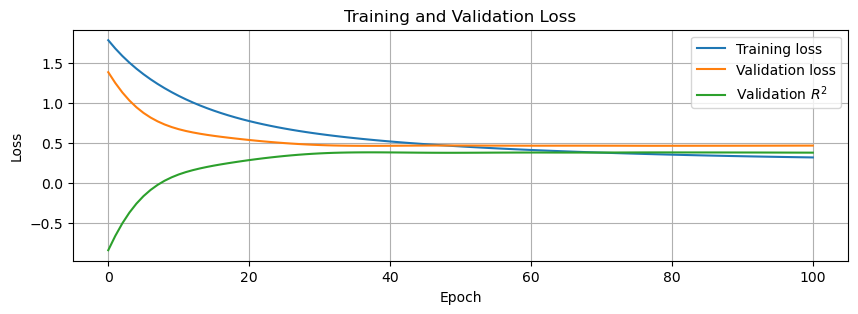

In [14]:
ultra_smooth_model, ultra_smooth_training_loss, ultra_smooth_validation_loss, ultra_smooth_validation_r_squared, ultra_smooth_global_mse_losses = train_nn(other_augmented_data, 
                                                                        other_y_augmented_train, 
                                                                        X_valid, 
                                                                        y_valid, 
                                                                        num_epochs=100, 
                                                                        learning_rate=1e-4, 
                                                                        weight_decay=1e-2, 
                                                                        verbose=True,
                                                                        current_gdp_idx=-1,
                                                                        custom_loss=lambda x, y: custom_loss(x, y, [smoothness_weight_ord1, smoothness_weight_ord2, 1, 1, 1, 1]),
                                                                        seed=SEED)

In [15]:
ultra_smooth_y_pred_valid = ultra_smooth_model(x_valid_t).clone().detach().cpu().numpy().squeeze()
ultra_smooth_y_pred_train = ultra_smooth_model(x_train_t).clone().detach().cpu().numpy().squeeze()
ultra_smooth_y_pred_hf = ultra_smooth_model(x_hf_t).clone().detach().cpu().numpy().squeeze()

## Mesure smoothness

Using cuda device


100%|██████████| 100/100 [00:00<00:00, 250.34it/s]


Final training loss: 0.01687396503984928
Final validation loss: 0.5011449456214905
Final validation R^2: 0.3338268707359172


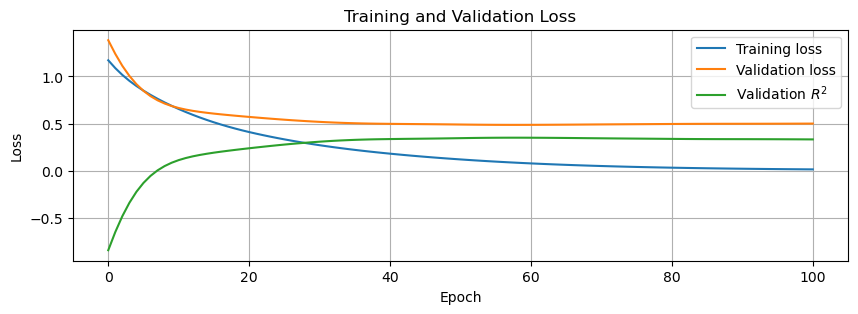

Basic R2 score: 0.3338268707359172
Adjusted R2 score: 0.42077457170289945


In [16]:
basic_model, basic_training_loss, basic_validation_loss, basic_validation_r_squared, basic_global_mse_losses = train_nn(X_train, 
                                                                        y_train, 
                                                                        X_valid, 
                                                                        y_valid, 
                                                                        num_epochs=100, 
                                                                        learning_rate=1e-4, 
                                                                        weight_decay=1e-2, 
                                                                        verbose=True,
                                                                        seed=SEED)

# Get the predictions
basic_y_pred_hf = basic_model(torch.tensor(x_hf, dtype=torch.float32).to(device)).clone().detach().cpu().numpy().squeeze()
basic_r2_score = results.r2_score(y_valid, basic_model(x_valid_t).clone().detach().cpu().numpy().squeeze())

# R2 on hf
adjusted_r2_score = results.r2_score(y_valid, model(x_valid_t).clone().detach().cpu().numpy().squeeze())

print(f"Basic R2 score: {basic_r2_score}")
print(f"Adjusted R2 score: {adjusted_r2_score}")

In [17]:
results.measure_smoothness(basic_y_pred_hf, preprocessor.dates_high_freq, preprocessor.country_high_freq)

[1.0244798588635369, 0.7010614006991247, 0.02145863465542067]

In [18]:
results.measure_smoothness(y_pred_hf, preprocessor.dates_high_freq, preprocessor.country_high_freq)

[0.2538351518911342, 0.2353138748041019, 0.007370403006844381]

In [19]:
results.measure_smoothness(ultra_smooth_y_pred_hf, preprocessor.dates_high_freq, preprocessor.country_high_freq)

[0.21028924938857274, 0.19741947665395024, 0.0058940197973845415]

## Compare on multiple weights

In [20]:
df_hf_squeezed = {
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': x_hf_t.clone().detach().cpu().numpy().squeeze(),
}

In [21]:
# basic_train_fn = lambda seed: train_nn(X_train, 
#                                  y_train, 
#                                  X_valid, 
#                                  y_valid,
#                                  num_epochs=100, 
#                                  learning_rate=1e-4, 
#                                  weight_decay=1e-2, 
#                                  verbose=False, 
#                                  seed=seed)

# smooth_train_fn = lambda seed: train_nn(augmented_data, 
#                                  y_augmented_train, 
#                                  X_valid, 
#                                  y_valid,
#                                  num_epochs=100, 
#                                  learning_rate=1e-4, 
#                                  weight_decay=1e-2, 
#                                  verbose=False, 
#                                  seed=seed, 
#                                  custom_loss=lambda x, y: custom_loss(x, y,  [smoothness_weight_ord1, smoothness_weight_ord2, 0, 0, 0, 0]))

# other_losses_importance = 0.5
# ultra_smooth_train_fn = lambda seed: train_nn(augmented_data, 
#                                                 y_augmented_train, 
#                                                 X_valid, 
#                                                 y_valid, 
#                                                 num_epochs=100, 
#                                                 learning_rate=1e-4, 
#                                                 weight_decay=1e-2, 
#                                                 verbose=False,
#                                                 current_gdp_idx=-1,
#                                                 seed=seed,
#                                               custom_loss=lambda x, y: custom_loss(x, y, [smoothness_weight_ord1, smoothness_weight_ord2] + 4 * [other_losses_importance]))


# basic_bootstrapped_results = results.bootstrap_ensemble(X_valid, y_valid, basic_train_fn, n_ensembling=100, seed=SEED, device=get_device(False), other_pred_set=df_hf_squeezed)
# smooth_bootstrapped_results = results.bootstrap_ensemble(X_valid, y_valid, smooth_train_fn, n_ensembling=100, seed=SEED, device=get_device(False), other_pred_set=df_hf_squeezed)
# ultra_smooth_bootstrapped_results = results.bootstrap_ensemble(X_valid, y_valid, ultra_smooth_train_fn, n_ensembling=100, seed=SEED, device=get_device(False), other_pred_set=df_hf_squeezed)


In [ ]:
def plot_summary(ensemble, metric_name):
    sns.histplot(ensemble, bins=30, kde=True)
    plt.axvline(x=np.median(ensemble), color='darkorange', linestyle='--', label=f'Median {metric_name}', linewidth=2)

    plt.xlabel(metric_name)
    plt.ylabel("Density")
    plt.title(f"Distribution of {metric_name} values")

NameError: name 'plot_summary' is not defined

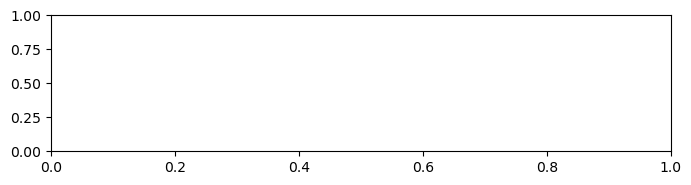

In [23]:
plt.figure(figsize=(8, 6))
plt.subplot(3, 1, 1)
plot_summary(basic_bootstrapped_results['rsquared_ensemble'], "$R^2$ Score")
plt.xlim(-0.2, 1)
plt.subplot(3, 1, 2)
plot_summary(smooth_bootstrapped_results['rsquared_ensemble'], "$R^2$ Score")
plt.xlim(-0.2, 1)
plt.subplot(3, 1, 3)
plot_summary(ultra_smooth_bootstrapped_results['rsquared_ensemble'], "$R^2$ Score")
plt.xlim(-0.2, 1)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(3, 1, 1)
plot_summary(basic_bootstrapped_results['other_pred_smoothness'], "Smoothness Error")
plt.xlim(0.1, 0.65)
plt.subplot(3, 1, 2)
plot_summary(smooth_bootstrapped_results['other_pred_smoothness'], "Smoothness Error")
plt.xlim(0.1, 0.6)
plt.subplot(3, 1, 3)
plot_summary(ultra_smooth_bootstrapped_results['other_pred_smoothness'], "Smoothness Error")
plt.xlim(0.1, 0.6)
plt.tight_layout()
plt.show()

## Parallelized Parameter Tuning

In [24]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

ord1_smoothness_weights = np.linspace(0, 50, 10) + [0]
ord2_smoothness_weights = np.linspace(30, 50, 10)
other_weights = np.linspace(0, 10, 20)

def train_and_evaluate(ord1_weight, ord2_weight, other_weight):

    train_fn = lambda seed: train_nn(other_augmented_data,
                                    other_y_augmented_train,
                                    X_valid,
                                    y_valid,
                                    num_epochs=100,
                                    learning_rate=1e-4,
                                    weight_decay=1e-2,
                                    verbose=False,
                                    custom_loss=lambda x, y: custom_loss(x, y, [ord1_weight, ord2_weight] + 4 * [other_weight]),
                                    current_gdp_idx=-1,
                                    seed=seed)

    bootstrapped_results = results.bootstrap_ensemble(X_valid, y_valid, train_fn, n_ensembling=15, seed=SEED, device=get_device(False), other_pred_set=df_hf_squeezed)

    r2_score = np.median(bootstrapped_results['rsquared_ensemble'])
    smoothness_loss = np.median(bootstrapped_results['other_pred_smoothness'])

    # Ensemble pred


    return (ord1_weight, ord2_weight, other_weight, r2_score, smoothness_loss, bootstrapped_results)

# Run in parallel
param_combinations = [(ord1, ord2, other_weight) for ord1 in ord1_smoothness_weights for ord2 in ord2_smoothness_weights for other_weight in other_weights]

batch6_parallel_results = Parallel(n_jobs=-1, backend='loky')(
    delayed(train_and_evaluate)(ord1, ord2, other_weight) for ord1, ord2, other_weight in tqdm(param_combinations)
)

# Unpack results
ord1_weight, ord2_weight, other_weight, validation_r_squared, smoothness_loss, bootstrapped_results = zip(*batch6_parallel_results)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [25]:
# Save parallel results
parallel_results_df = pd.DataFrame({
    'ord1_weight': ord1_weight,
    'ord2_weight': ord2_weight,
    'other_weight': other_weight,
    'validation_r_squared': validation_r_squared,
    'smoothness_loss': smoothness_loss,
    'bootstrapped_results': bootstrapped_results
})

parallel_results_df.to_pickle('paper_data/smoothing_objective_function_all_metrics_6_batchsize_bootstrappedresults.pkl')

In [26]:
ord1_weight, ord2_weight, other_weight, validation_r_squared, smoothness_loss, bootstrapped_results = zip(*batch6_parallel_results)

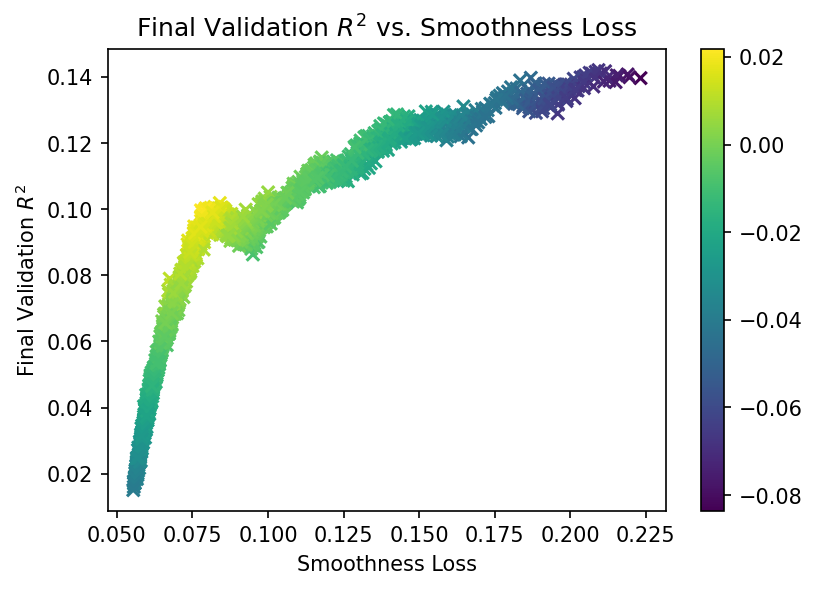

(22.22222222222222, 47.77777777777778, 5.263157894736842)

In [27]:
N1 = len(ord1_smoothness_weights)
N2 = len(ord2_smoothness_weights)
N3 = len(other_weights)

# Create mapping from (ord1_weight, ord2_weight) to grid indices
ord1_to_idx = {w: i for i, w in enumerate(ord1_smoothness_weights)}
ord2_to_idx = {w: i for i, w in enumerate(ord2_smoothness_weights)}
ord_other_idx = {w: i for i, w in enumerate(other_weights)}

# Initialize empty arrays for final metrics
final_train_loss = np.zeros((N1, N2, N3))
final_val_loss = np.zeros((N1, N2, N3))
final_val_r2 = np.zeros((N1, N2, N3))
final_smoothness_mean = np.zeros((N1, N2, N3))
final_validation_mse_loss = np.zeros((N1, N2, N3))  # example if needed
final_training_mse_loss = np.zeros((N1, N2, N3))  # example if needed

for ord1, ord2, other_weight, val_r2, sm_loss in zip(ord1_weight, ord2_weight, other_weight, validation_r_squared, smoothness_loss):
    i = ord1_to_idx[ord1]
    j = ord2_to_idx[ord2]
    z = ord_other_idx[other_weight]

    final_val_r2[i, j, z] = val_r2
    final_smoothness_mean[i, j, z] = sm_loss

# Plot R^2 over the smoothness strength scatter plot for all values
plt.figure(figsize=(6, 4), dpi=150)
plt.scatter(final_smoothness_mean.flatten(), final_val_r2.flatten(), c=(final_val_r2-final_smoothness_mean).flatten(), cmap='viridis', marker='x')
plt.colorbar()
plt.xlabel('Smoothness Loss')
plt.ylabel('Final Validation $R^2$')
plt.title('Final Validation $R^2$ vs. Smoothness Loss')
plt.show()

idxs = np.unravel_index(np.nanargmax(final_val_r2-final_smoothness_mean), final_val_r2.shape)
best_ord1 = ord1_smoothness_weights[idxs[0]]
best_ord2 = ord2_smoothness_weights[idxs[1]]
best_other = other_weights[idxs[2]]

best_ord1, best_ord2, best_other

In [29]:
ord1_smoothness_weights = np.linspace(0, 50, 7) + [0]
ord2_smoothness_weights = np.linspace(30, 50, 7)
other_weights = np.linspace(0, 10, 15)


In [30]:
def train_and_evaluate(ord1_weight, ord2_weight, other_weight):

    train_fn = lambda seed: train_nn(augmented_data,
                                    y_augmented_train,
                                    X_valid,
                                    y_valid,
                                    num_epochs=100,
                                    learning_rate=1e-4,
                                    weight_decay=1e-2,
                                    verbose=False,
                                    custom_loss=lambda x, y: custom_loss(x, y, [ord1_weight, ord2_weight] + 4 * [other_weight]),
                                    current_gdp_idx=-1,
                                    seed=seed)

    bootstrapped_results = results.bootstrap_ensemble(X_valid, y_valid, train_fn, n_ensembling=15, seed=SEED, device=get_device(False), other_pred_set=df_hf_squeezed)

    r2_score = np.median(bootstrapped_results['rsquared_ensemble'])
    smoothness_loss = np.median(bootstrapped_results['other_pred_smoothness'])

    return (ord1_weight, ord2_weight, other_weight, r2_score, smoothness_loss, bootstrapped_results)

# Run in parallel
param_combinations = [(ord1, ord2, other_weight) for ord1 in ord1_smoothness_weights for ord2 in ord2_smoothness_weights for other_weight in other_weights]

batch4_parallel_results = Parallel(n_jobs=-1, backend='loky')(
    delayed(train_and_evaluate)(ord1, ord2, other_weight) for ord1, ord2, other_weight in tqdm(param_combinations)
)

# Unpack results
ord1_weight, ord2_weight, other_weight, validation_r_squared, smoothness_loss, bootstrapped_results = zip(*batch4_parallel_results)

# Save parallel results
parallel_results_df = pd.DataFrame({
    'ord1_weight': ord1_weight,
    'ord2_weight': ord2_weight,
    'other_weight': other_weight,
    'validation_r_squared': validation_r_squared,
    'smoothness_loss': smoothness_loss,
    'bootstrapped_results': bootstrapped_results
})

parallel_results_df.to_pickle('paper_data/smoothing_objective_function_all_metrics_4_batchsize_bootstrappedresults.pkl')

  0%|          | 0/735 [00:00<?, ?it/s]